In [1]:
!ls ../input/shopee-generate-data-for-triplet-loss/train_triplets_imgs.csv
!ls ../input/shopee-product-matching/
!ls ../input/shopee-generate-data-for-triplet-loss/train_triplets_titles.csv
!ls ../input/shopee-pytorch-siamese-triplet-loss-xlmrobe-cd1846/xlmroberta_256_fold0.pth

../input/shopee-generate-data-for-triplet-loss/train_triplets_imgs.csv
sample_submission.csv  test.csv  test_images  train.csv  train_images
../input/shopee-generate-data-for-triplet-loss/train_triplets_titles.csv
../input/shopee-pytorch-siamese-triplet-loss-xlmrobe-cd1846/xlmroberta_256_fold0.pth


In [2]:
# import sys
# sys.path.append ('/kaggle/input/pytorch-images-seresnet')
import os
import gc
import time
import math
import random
import datetime
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
from   torch.nn import init
from   torch.nn import CrossEntropyLoss, MSELoss
from   torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
from   torch.nn import Parameter
from   torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from   transformers import AdamW, get_cosine_schedule_with_warmup
from   torch.cuda.amp import autocast, GradScaler

from   transformers import BertForSequenceClassification, BertConfig, AutoTokenizer, AutoModelForSequenceClassification
from   transformers import RobertaTokenizer, RobertaForSequenceClassification, XLMRobertaModel

from   sklearn.model_selection import StratifiedKFold, GroupKFold
# import timm

import albumentations as A
from   albumentations import *
from   albumentations.pytorch import ToTensorV2
from   albumentations.core.transforms_interface import DualTransform
from   albumentations.augmentations import functional as AF
import cv2

from   tqdm import tqdm
from   pprint import pprint
from   functools import partial
import matplotlib.pyplot as plt
# from GPUtil import showUtilization as gpu_usage
# from   numba import cuda
import warnings
warnings.filterwarnings ("ignore")

In [3]:
class CFG:
    device       = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')
    num_workers  = 8
    model_name   = 'xlmroberta'        # ['deit_base_patch16_224', 'vit_base_patch16_384', 'resnext50_32x4d', 'tf_efficientnet_b7_ns']
    margin       = 1.0
    size         = 128
    isTrain      = True
    isFreeze     = True
    lr           = 1e-4
    epochs       = 6
    warmup_steps = 0.50                    # if float: these many epochs are with frozen model at the beginning, if int = actual steps
    lr_num_cycles= 0.5
    epochsNx     = 1
    weight_decay = 1e-6
    max_grad_norm= 1000.0
    seed         = 42
    n_fold       = 10
    train_fold   = [0]                      # [0, 1, 2, 3, 4]
    print_every  = 100
    adam_epsilon = 1e-8
    train_batch_size = 12
    eval_batch_size  = 112
    img_ext          = '.png'
    img_col          = "image_id"
    raw_label_cols   = 'class_id'
    label_cols       = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    target_size      = len (label_cols)
    model_infer_path_prefix = "."
    model_train_path_prefix = "."
    text_triplets_csv= "../input/shopee-generate-data-for-triplet-loss/train_triplets_titles.csv"
    train_path       = '../input/shopee-product-matching/train_images'
    # train_csv        = '../input/vinbigdata-chest-xray-abnormalities-detection/train.csv'
    # test_path        = '../input/vinbigdata-chest-xray-resized-png-1024x1024/test'
    output_dir       = './results'        # output directory    
    eval_steps       = 0.5                # if float: these many epochs are with frozen model at the beginning, if int = actual steps 
    max_steps        = 0
    MODEL            = None

In [4]:
def init_logger (log_file=CFG.output_dir+'train.log'):
    
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger (__name__)
    logger.setLevel (INFO)
    handler1 = StreamHandler ()
    handler1.setFormatter (Formatter ("%(message)s"))
    handler2 = FileHandler (filename=log_file)
    handler2.setFormatter (Formatter ("%(message)s"))
    logger.addHandler (handler1)
    logger.addHandler (handler2)
    return logger

In [5]:
def seed_everything (seed):
    
    random.seed (seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed (seed)
    torch.manual_seed (seed)
    torch.cuda.manual_seed (seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    return

# Dataset

In [6]:
# see image triplets
df = pd.read_csv (CFG.text_triplets_csv)
TRAIN_DF = df.iloc[:(df.shape[0]*9//10)]
TEST_DF  = df.iloc[(df.shape[0]*9//10):]
del df
gc.collect ()
TEST_DF.head ()

,anchor,positive,negative
30825,TOTEBAG KPOP PAKAI RESLETING / TOTE BAG KPOP /...,RESLETING TAS TOTE TOTEBAG KPOP / TOTE BAG KPO...,[BPOM] Cosrx Clear Fit Master Patch isi 18pcs
30826,Stroller Koper Cabin Size Kereta Dorong Bayi B...,Dorongan kereta bayi stroller BabyDoes Pronto ...,Masker Gelatin Organic 10 Gram by Poupeepou
30827,Dakron isi Boneka 100grm,Dakron Super 100 gram/isi boneka,Lakban Besar OPP Isolasi Selotip TEBAL EKA TAP...
30828,Cussons Baby Hair and Body Wash 100ml + 100ml,Cussons Baby Hair & Body Wash Mild Gentle 200ml,Stelan baju tidur 3in1~ XL
30829,Cokelat SNICKERS 35 Gram,Coklat SNICKERS 35gr import Inggris PROMO!!,Sendok Makan Bayi dan Anak Motif Tangan Mickey...


# Xlm-Roberta

In [7]:
bert_model_name = 'joeddav/xlm-roberta-large-xnli'   # 'xlm-roberta-large'
max_len         = CFG.size
tokenizer       = AutoTokenizer.from_pretrained (bert_model_name)

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

In [8]:
def encode (premise):
    
    encoded_dict = tokenizer (
        premise,                   # 1st of the Sentence pair to encode.
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        truncation=True,           # just max_len will not automatically truncate
        max_length = max_len,      # Pad & truncate all sentences.
        padding='max_length',
        return_attention_mask = True,   # Construct attn. masks.
        return_tensors = 'pt',     # Return pytorch tensors.
    ) 
    # print ('encoded_dict =', encoded_dict)
    # 1-D tensors are expected for a sample. Hence squeeze these 2-D tensors e.g [1,256] shaped tensors to 1-D [256] shape 
    for k in encoded_dict:
        encoded_dict[k] = torch.squeeze (encoded_dict[k])
    return encoded_dict

In [9]:
class TripletTextDataset (Dataset):
    
    def __init__(self, df=TRAIN_DF):
        self.df = df   # pd.read_csv (img_triplets_csv).reset_index (drop=True)
        return
    
    def __getitem__(self, index):
        
        triplet  = self.df.iloc[index]
        anchor   = triplet['anchor']
        positive = triplet['positive']
        negative = triplet['negative']
        
        anchor   = encode (anchor)
        positive = encode (positive)
        negative = encode (negative)
        return (anchor, positive, negative)
    
    def __len__(self):
        return self.df.shape[0]

In [10]:
def plot_txt (dataset_show):
        
    for i in range (2):
            idx = np.random.randint (0, len (dataset_show))
            dict1, dict2, dict3 = dataset_show[idx] 
            print ('Anchor =',  dict1)
            print ('+ve = ', dict2)
            print ('-ve = ', dict3)
    return 

TR_DATASET = TripletTextDataset ()
plot_txt (TR_DATASET)
del TR_DATASET
gc.collect ()

Anchor = {'input_ids': tensor([     0, 156869,   8344,     56,  33362,  32439,     64,   7311,   8753,
          1619,      2,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,  

64

> # Loss Functions

In [11]:
def get_criterion (margin):
    
    criterion = nn.MarginRankingLoss (margin=margin)
    return criterion

# Model

In [12]:
class MyGAPModelForSeqClf (nn.Module):
    
    def __init__(self, bert_model_name, outputCount=3, drop_prob=0.1, nonlin=nn.ReLU ()):
        
        super (MyGAPModelForSeqClf, self).__init__()
        self.model       = AutoModelForSequenceClassification.from_pretrained (bert_model_name).base_model  # adding .base_model if using pretrained XLMRobertaForSequenceClassification
        self.drop_prob   = drop_prob
        self.nonlin      = nonlin
        self.outputCount = outputCount
        hidden_size      = self.model.config.hidden_size
        self.dense       = nn.Linear (hidden_size, hidden_size)
        self.batchnorm   = nn.BatchNorm1d (hidden_size)          # Not Used
        self.outDense    = nn.Linear (hidden_size, outputCount)  # Not Used
        self.dropout     = nn.Dropout (drop_prob)                # Not Used
        self.outActivtn  = nn.LogSoftmax (dim=1)                 # Not Used
        self.NLLLoss     = nn.NLLLoss ()                         # Not Used
        return
    
    def freeze (self):
        
        for param in self.model.base_model.parameters ():
            param.requires_grad = False
        for param in self.dense.parameters ():
            param.requires_grad = True
        return
    
    def unfreeze (self):
        
        for param in self.model.base_model.parameters ():
            param.requires_grad = True
        for param in self.dense.parameters ():
            param.requires_grad = True
        return
    
    def forward (self, input_ids, attention_mask, token_type_ids=None, labels=None, **kwargs):
        
        last_hidden_states = None
        
        # The base bert model do not take labels as input
        if token_type_ids is None:
            moutput = self.model (input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_states = moutput[0]
        else:
            moutput = self.model (input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            last_hidden_states = moutput[0]
        #print('last_hidden_states.size=', last_hidden_states.size())
        
        # GAP: last_hidden_states shape = batch_size * max_seq_len * emb_dim(1024?)
        # output shape = batch_size * emb_dim(1024?)  i.e avg across the sequence
        last_hidden_states = torch.mean (last_hidden_states, 1)             #;print('GAP last_hidden_states.size=', last_hidden_states.size())
        # fcnn
        X = self.dense (last_hidden_states)
        return X

In [13]:
class TripletModel (nn.Module):
    
    def __init__(self, embeddingModel):
        
        super (TripletModel, self).__init__()
        self.embeddingModel = embeddingModel
    
    def forward (self, i1, i2, i3):
        
        E1 = self.embeddingModel (**i1)
        E2 = self.embeddingModel (**i2)
        E3 = self.embeddingModel (**i3)
        return E1, E2, E3
    
    def freeze (self):
        self.embeddingModel.freeze ()
        return
    
    def unfreeze (self):
        self.embeddingModel.unfreeze ()
        return

In [14]:
model = MyGAPModelForSeqClf (bert_model_name)

# load the pretrained model which was trained this code only (by commenting out these 4 line)
# try:
#     model.load_state_dict (torch.load ("../input/robertagapxnlimnlirishi/roberta-gap-xnli-mnli-rishi/my_model.bin"))
# except:
#     model.load_state_dict (torch.load ("../input/robertagapxnlimnlirishi/roberta-gap-xnli-mnli-rishi/my_model.bin", map_location='cpu'))

model = TripletModel (model)

import warnings
warnings.filterwarnings ("ignore")
model.to (CFG.device)
CFG.MODEL = model

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Trainer Helpers

In [15]:
def format_time (elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str (datetime.timedelta (seconds=elapsed_rounded))

# Trainer

In [16]:
class MyTrainer:
    
    def __init__(self, fold, model, train_dataset, eval_dataset, criterion, 
                 checkpoint_path=None, isResume=False):
        
        self.fold             = fold
        self.start_epoch      = 0
        self.model            = model
        # load checkpoint
        if checkpoint_path is not None:
            if isResume:
                self.start_epoch = self.load_checkpoint (checkpoint_path, isResume=True) + 1
            else:
                self.load_checkpoint (checkpoint_path, isResume=False)
        self.model            = self.model.to (CFG.device)
        if CFG.isFreeze:
            self.model.freeze ()
        else:
            self.model.unfreeze ()
        CFG.MODEL             = self.model
        self.train_dataset    = train_dataset
        self.eval_dataset     = eval_dataset
        self.criterion        = criterion
        self.isTrained        = False
        self.device           = CFG.device
        self.optimizer        = AdamW (self.model.parameters (), lr=CFG.lr, eps=CFG.adam_epsilon, weight_decay=CFG.weight_decay)
        self.epochs           = CFG.epochs
        self.set_dataLoaders ()
        self.training_stats   = []
        self.modelFile        = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}.pth"
        if eval_dataset is not None:
            self.minLossModelFile = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}_min_val_loss.pth"
            self.maxAccModelFile  = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}_max_val_acc.pth"
        else:
            self.minLossModelFile = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}_min_tr_loss.pth"
            self.maxAccModelFile  = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}_max_tr_acc.pth"
        
        self.min_val_loss         = 9999
        self.min_train_loss       = 9999
        self.max_val_acc          = -1    
        return
    
    def set_dataLoaders (self):
        # Create the DataLoaders for our training and validation sets.
        
        if isinstance (self.train_dataset, torch.utils.data.IterableDataset):
            train_sampler = None
        else:
            train_sampler = RandomSampler (self.train_dataset)           # Better use RandomSampler
        train_dataloader  = DataLoader (
                    self.train_dataset,                                  # The training samples.
                    sampler     = train_sampler,                           
                    batch_size  = CFG.train_batch_size,
                    num_workers = CFG.num_workers,
                    pin_memory  = True
        )
        # train_dataloader  = DataLoader (self.train_dataset, batch_size=CFG.train_batch_size) # TODO: comment this
        validation_dataloader = None
        if self.eval_dataset:
            validation_dataloader = DataLoader (
                        self.eval_dataset, 
                        sampler     = SequentialSampler (self.eval_dataset),
                        batch_size  = CFG.eval_batch_size,
                        num_workers = CFG.num_workers,
                        pin_memory  = False
            )
            # validation_dataloader  = DataLoader (self.eval_dataset, batch_size=CFG.eval_batch_size) # TODO: comment this
        
        if type (CFG.warmup_steps) is float:
            CFG.warmup_steps = int (CFG.warmup_steps * len (train_dataloader))
        # Total number of training steps is [number of batches] x [number of epochs]
        num_training_steps = len (train_dataloader) * self.epochs        
        lr_scheduler = get_cosine_schedule_with_warmup (self.optimizer, num_cycles=CFG.lr_num_cycles,
                        num_warmup_steps=CFG.warmup_steps, num_training_steps=num_training_steps)
        
        if type (CFG.eval_steps) is float:
            CFG.eval_steps = int (CFG.eval_steps * len (train_dataloader))
        self.train_dataloader, self.validation_dataloader, self.lr_scheduler, self.num_training_steps=train_dataloader, validation_dataloader, lr_scheduler, num_training_steps
        return
            
    def test_iterate_dataloader (self):
        
        for step, batch in enumerate (self.train_dataloader):
            print (step)
            print (batch)
            break
        return
    
    def save_checkpoint (self, epoch, path):
        
        checkpoint = {
            'epoch'               : epoch,
            'model_state_dict'    : self.model.state_dict (),
            'optimizer_state_dict': self.optimizer.state_dict (),
            'lr_sched_state_dict' : self.lr_scheduler.state_dict (),
            'training_stats'      : self.training_stats,
            'max_val_acc'         : self.max_val_acc,
            'min_train_loss'      : self.min_train_loss,
            'min_val_loss'        : self.min_val_loss,
        }
        torch.save (checkpoint, path)
        gc.collect (); torch.cuda.empty_cache ()
        print ("saved checkpoint", path)
        return
    
    def load_checkpoint (self, path, isResume=False):
        
        epoch      = 0
        checkpoint = torch.load (path, map_location=torch.device ('cpu'))
        self.model.load_state_dict (checkpoint['model_state_dict'])
        if isResume:
            
            self.optimizer.load_state_dict (checkpoint['optimizer_state_dict'])
            self.lr_scheduler.load_state_dict (checkpoint['lr_sched_state_dict'])
            epoch = checkpoint['epoch']
            self.training_stats  = checkpoint['training_stats']
            self.min_val_loss    = checkpoint['min_val_loss']
            self.min_train_loss  = checkpoint['min_train_loss']
            self.max_val_acc     = checkpoint['max_val_acc']
            print ("Loaded model, optimizer, and lr_scheduler from -", path)
        else:
            print ("Loaded model from -", path)
            
        self.model.train ()
        return epoch
    
    def train (self):
        
        seed_everything (seed=CFG.seed)
        step             = 0
        total_t0         = time.time ()
        scaler           = GradScaler()
        for epoch_i in range (self.start_epoch, self.epochs):
            
            avg_epoch_train_loss   = 0
            total_epoch_train_loss = 0
            print('======== Epoch {:} / {:} ========'.format (epoch_i + 1, self.epochs))
            t0 = time.time ()
            self.model.train ()
            for stp, batch in tqdm (enumerate (self.train_dataloader), total=len(self.train_dataloader)):
                
                # Print Stats
                # if step % CFG.print_every == 0:
                #     elapsed = format_time (time.time() - t0)
                #     print ('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format (step, len (self.train_dataloader), elapsed))                
                if ((CFG.max_steps > 0 and CFG.max_steps < step) or 
                    (CFG.eval_steps>0 and stp==CFG.eval_steps)): # or step==0):   # TODO: rm this comment
                    
                    self.save_checkpoint (epoch_i, self.modelFile)
                    training_time = format_time (time.time () - t0)            
                    if self.validation_dataloader:
                        
                        avg_val_loss, avg_val_accuracy, validation_time = self.evaluate (epoch_i, avg_epoch_train_loss, training_time)
                        # save this model if the eval loss decreases from the minimum so far
                        checkpoint_epoch = epoch_i
                        if stp==CFG.eval_steps:
                            # don't count this epoch in the checkpoint since this epoch 
                            # has not completed. Hence, checkpoint at prev epoch
                            checkpoint_epoch = epoch_i-1
                        if avg_val_loss < self.min_val_loss:                             
                            self.min_val_loss = avg_val_loss
                            self.save_checkpoint (checkpoint_epoch, self.minLossModelFile)
                        if avg_val_accuracy > self.max_val_acc:
                            self.max_val_acc = avg_val_accuracy
                            self.save_checkpoint (checkpoint_epoch, self.maxAccModelFile)
                    if CFG.max_steps > 0 and CFG.max_steps < step:
                        
                        print ("")
                        print ("Training complete!")
                        print ("Total training took {:} (h:mm:ss)".format (format_time (time.time ()-total_t0)))
                        self.isTrained = True
                        self.model.cpu ()
                        self.model.eval ()
                        self.save_checkpoint (epoch_i, self.modelFile)
                        try:
                            torch.cuda.empty_cache ()
                            self.plot_train_stats (self.training_stats)
                        except:
                            pass
                        return pd.DataFrame (self.training_stats)
                
                ########################################################
                # Train
                ########################################################
                # self.model.zero_grad ()
                for i in [0,1,2]:
                    for k in batch[i]:
                        batch[i][k] = batch[i][k].to (self.device)
                
                anc_imgs = batch[0]
                pos_imgs = batch[1]
                neg_imgs = batch[2]
                with autocast():
                    
                    E1, E2, E3 = self.model (anc_imgs, pos_imgs, neg_imgs)
                    dist_E1_E2 = F.pairwise_distance (E1, E2, 2)
                    dist_E1_E3 = F.pairwise_distance (E1, E3, 2)
                    target = torch.FloatTensor (dist_E1_E2.size()).fill_ (-1)
                    target = target.to (CFG.device)
                    loss = self.criterion (dist_E1_E2, dist_E1_E3, target)
                    scaler.scale (loss).backward ()
                    # torch.nn.utils.clip_grad_norm_ (self.model.parameters (), CFG.max_grad_norm)
                    scaler.step (self.optimizer)
                    scaler.update ()
                    self.optimizer.zero_grad ()
                    self.lr_scheduler.step ()
                    
                total_epoch_train_loss += loss.cpu ().item ()
                avg_epoch_train_loss    = total_epoch_train_loss / (stp+1)
                step += 1
            # all steps of an epoch end
            
            # Measure how long this epoch took.
            training_time = format_time (time.time () - t0)            
            print ("  Average training loss: {0:.4f}".format (avg_epoch_train_loss))
            print ("  Training epcoh took: {:}".format (training_time))            
            if self.validation_dataloader:    
                
                avg_val_loss, avg_val_accuracy, validation_time = self.evaluate (epoch_i, avg_epoch_train_loss, training_time)
                # save this epoch's model if the eval loss decreases from the minimum so far
                if avg_val_loss < self.min_val_loss:                    
                    self.min_val_loss = avg_val_loss
                    self.save_checkpoint (epoch_i, self.minLossModelFile)
                if avg_val_accuracy > self.max_val_acc:
                    self.max_val_acc = avg_val_accuracy
                    self.save_checkpoint (epoch_i, self.maxAccModelFile)
            else:                
                training_stats.append ({
                    'epoch'         : epoch_i + 1,
                    'training_loss' : avg_epoch_train_loss,
                    'training_time' : training_time,
                })
                if avg_train_loss < self.min_train_loss:                     
                    self.min_train_loss = avg_train_loss
                    self.save_checkpoint (epoch_i, self.minLossModelFile)
            self.save_checkpoint (epoch_i, self.modelFile)
            # 1 epoch end
        # all epochs end
        
        # just get the best class thresholds at the end
        if self.validation_dataloader:
            print ('At training end, threshold Adjustment (last row of the train summary DF)')
            print (self.evaluate (epoch_i, avg_epoch_train_loss, training_time, isThreshAdjust=True))
            print ('<: avg_val_loss, avg_val_accuracy, validation_time')
        
        print ("***** Training complete! *****")
        print ("Total training took {:} (h:mm:ss)".format (format_time (time.time ()-total_t0)))
        self.isTrained = True
        self.model.cpu ()
        self.model.eval ()
        try:
            torch.cuda.empty_cache ()
            self.plot_train_stats (self.training_stats)
        except:
            pass
        return pd.DataFrame (self.training_stats)
    
    def evaluate (self, epoch_i, avg_train_loss=999, training_time=999, isThreshAdjust=False):
        
        t0           = time.time ()
        all_labels   = []
        all_pred_prs = []
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        self.model.eval ()
        
        # Tracking variables
        total_eval_accuracy  = 0
        total_eval_loss      = 0
        nb_eval_steps        = 0
        correct_pred_count   = 0
        total_pred_count     = 0
        # Evaluate data for one epoch
        for batch in self.validation_dataloader:
            with torch.no_grad ():
                
                for i in [0,1,2]:
                    for k in batch[i]:
                        batch[i][k] = batch[i][k].to (self.device)
                
                anc_imgs = batch[0]
                pos_imgs = batch[1]
                neg_imgs = batch[2]            
                E1, E2, E3 = self.model (anc_imgs, pos_imgs, neg_imgs)
                dist_E1_E2 = F.pairwise_distance (E1, E2, 2)
                dist_E1_E3 = F.pairwise_distance (E1, E3, 2)
                target     = torch.FloatTensor (dist_E1_E2.size()).fill_ (-1).to (CFG.device)
                loss       = self.criterion (dist_E1_E2, dist_E1_E3, target).cpu ().detach ()
            
            correct_pred_count += sum ((dist_E1_E2 < dist_E1_E3) + 0.0)
            total_pred_count   += len (dist_E1_E2) 
            total_eval_loss    += loss.item ()     
        
        avg_val_loss     = total_eval_loss / len (self.validation_dataloader)
        avg_val_accuracy = correct_pred_count / total_pred_count
        print ("Val Loss: {0:.4f}".format (avg_val_loss))
        print ("Val Accuracy: {0:.4f}".format (avg_val_accuracy))
        validation_time = format_time (time.time () - t0)
        self.training_stats.append ({
                'epoch'         : epoch_i + 1,
                'training_loss' : avg_train_loss,
                'eval_loss'     : avg_val_loss,
                'eval_accuracy' : avg_val_accuracy,
                'training_time' : training_time,
                'eval_time'     : validation_time                   
        })
        self.model.train ()
        print ("Validation took {:} (h:mm:ss)".format (format_time (time.time () - t0)))
        return avg_val_loss, avg_val_accuracy, validation_time
        
        
    def plot_train_stats (self, training_stats):
        """
        Draw Classification Report curve
        """
        
        accuracies = eval_losses = tr_losses = epochs = -1
        epochs = len (training_stats)
        if 'eval_accuracy' in training_stats[0]:
            accuracies = [e['eval_accuracy'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=accuracies, label='val_accuracy')
        if 'eval_loss' in training_stats[0]:
            eval_losses= [e['eval_loss'] for e in training_stats]
        if 'training_loss'  in training_stats[0]:
            tr_losses  = [e['training_loss'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=tr_losses,  label='tr_losses')
            
        plt.show ()
        print ('accuracies :', accuracies)        
        print ('eval_losses:', eval_losses)
        print ('tr_losses  :', tr_losses)
        return
    
    def get_trained_model (self):
        
        if self.isTrained:
            return self.model.eval ()
        return None

In [17]:
def free_gpu_cache ():
    
    # print("Initial GPU Usage")
    # gpu_usage()                             

    torch.cuda.empty_cache()

    # cuda.select_device(0)
    # cuda.close()
    # cuda.select_device(0)

    # print("GPU Usage after emptying the cache")
    # gpu_usage()
    return

# free_gpu_cache()           

## Train

In [18]:
def train_fold_loop (checkpoint_path=None):

    print (f"========== training ==========")
    fold = 0 # fold is not used
    criterion      = get_criterion (CFG.margin)
    model          = CFG.MODEL
    if model is None and checkpoint_path is None:
        print ("CFG.MODEL is None")
        model      = getModel (fold, isTrain=True)
        model      = model.float()
    elif model is not None and checkpoint_path is not None:
        pass
        # checkpoint_path = None
    elif model is None and checkpoint_path is not None:
        print ("CFG.MODEL is None")
        model      = getModel (fold, isTrain=False)
        model      = model.float()
        
    train_dataset  = TripletTextDataset ()
    valid_dataset  = TripletTextDataset (TEST_DF)
    trainer        = MyTrainer (
        fold            = fold,
        model           = model,
        train_dataset   = train_dataset,
        eval_dataset    = valid_dataset,
        criterion       = criterion,
        checkpoint_path = checkpoint_path
    )
    metrics = trainer.train ()
    return metrics
    
    # To plot lr uncomment this
    # lrs = []
    # for i in range (CFG.epochs*len (trainer.train_dataloader)):
    #     trainer.lr_scheduler.step ()
    #     lrs.append (trainer.optimizer.param_groups[0]["lr"])
    # print (lrs)
    # plt.plot (lrs)
    # plt.show ()

In [19]:
def train_main (checkpoint_path=None):
    
    # print (f"========== train_main() ==========")
    if CFG.isTrain:        
        valid_scores_df = pd.DataFrame ()
        for fold in range (CFG.n_fold):
            if fold in CFG.train_fold:
                
                valid_scores_fold_df = train_fold_loop (checkpoint_path)
                # valid_scores_fold = np.array (valid_scores_fold).reshape ((1, -1))
                valid_scores_df = valid_scores_df.append (valid_scores_fold_df)
                
        print (f"========== CV ==========")
        # print (valid_scores_df)
        # valid_scores = np.vstack (valid_scores)
        # valid_scores = np.mean (valid_scores, axis=0)
        valid_scores = valid_scores_df.iloc[-1, :]  #.mean ()
        print ("CV Scores :-");  print (valid_scores)
    return valid_scores_df

# Single config training

!mkdir -p /kaggle/working/Output/
!touch /kaggle/working/Output/train.log
gc.collect ()
model_names = timm.list_models (pretrained=True)
model_names = timm.list_models ('*resnet*', pretrained=True)
pprint (model_names)
LOGGER = init_logger ()
seed_everything (seed=CFG.seed)

valid_scores_df = train_main ()

valid_scores_df

# To train, uncomment these

In [20]:
!ls ../input/shopee-pytorch-siamese-triplet-loss-xlmrobe-cd1846/xlmroberta_256_fold0.pth

../input/shopee-pytorch-siamese-triplet-loss-xlmrobe-cd1846/xlmroberta_256_fold0.pth


***** Training, freeze=True *****
========== training ==========
Loaded model from - ../input/shopee-pytorch-siamese-triplet-loss-xlmrobe-cd1846/xlmroberta_256_fold0.pth
======== Epoch 1 / 5 ========


 50%|████▉     | 963/1927 [11:43<11:43,  1.37it/s]

saved checkpoint ./xlmroberta_128_fold0.pth
Val Loss: 0.3053
Val Accuracy: 0.8686
Validation took 0:02:29 (h:mm:ss)
saved checkpoint ./xlmroberta_128_fold0_min_val_loss.pth
saved checkpoint ./xlmroberta_128_fold0_max_val_acc.pth


100%|██████████| 1927/1927 [26:25<00:00,  1.22it/s]

  Average training loss: 0.4025
  Training epcoh took: 0:26:26


Val Loss: 0.2841
Val Accuracy: 0.8782
Validation took 0:02:29 (h:mm:ss)
saved checkpoint ./xlmroberta_128_fold0_min_val_loss.pth
saved checkpoint ./xlmroberta_128_fold0_max_val_acc.pth
saved checkpoint ./xlmroberta_128_fold0.pth
======== Epoch 2 / 5 ========


 50%|████▉     | 963/1927 [11:43<11:46,  1.36it/s]

saved checkpoint ./xlmroberta_128_fold0.pth
Val Loss: 0.2799
Val Accuracy: 0.8797
Validation took 0:02:29 (h:mm:ss)
saved checkpoint ./xlmroberta_128_fold0_min_val_loss.pth
saved checkpoint ./xlmroberta_128_fold0_max_val_acc.pth


100%|██████████| 1927/1927 [27:02<00:00,  1.19it/s]

  Average training loss: 0.4315
  Training epcoh took: 0:27:03


Val Loss: 0.2761
Val Accuracy: 0.8803
Validation took 0:02:29 (h:mm:ss)
saved checkpoint ./xlmroberta_128_fold0_min_val_loss.pth
saved checkpoint ./xlmroberta_128_fold0_max_val_acc.pth
saved checkpoint ./xlmroberta_128_fold0.pth
======== Epoch 3 / 5 ========


 50%|████▉     | 963/1927 [11:43<11:45,  1.37it/s]

saved checkpoint ./xlmroberta_128_fold0.pth
Val Loss: 0.2679
Val Accuracy: 0.8899
Validation took 0:02:29 (h:mm:ss)
saved checkpoint ./xlmroberta_128_fold0_min_val_loss.pth
saved checkpoint ./xlmroberta_128_fold0_max_val_acc.pth


100%|██████████| 1927/1927 [26:51<00:00,  1.20it/s]

  Average training loss: 0.4088
  Training epcoh took: 0:26:52


Val Loss: 0.2609
Val Accuracy: 0.8905
Validation took 0:02:29 (h:mm:ss)
saved checkpoint ./xlmroberta_128_fold0_min_val_loss.pth
saved checkpoint ./xlmroberta_128_fold0_max_val_acc.pth
saved checkpoint ./xlmroberta_128_fold0.pth
======== Epoch 4 / 5 ========


 50%|████▉     | 963/1927 [11:43<11:46,  1.36it/s]

saved checkpoint ./xlmroberta_128_fold0.pth
Val Loss: 0.2564
Val Accuracy: 0.8923
Validation took 0:02:29 (h:mm:ss)
saved checkpoint ./xlmroberta_128_fold0_min_val_loss.pth
saved checkpoint ./xlmroberta_128_fold0_max_val_acc.pth


100%|██████████| 1927/1927 [26:52<00:00,  1.19it/s]

  Average training loss: 0.4006
  Training epcoh took: 0:26:53


Val Loss: 0.2545
Val Accuracy: 0.8943
Validation took 0:02:29 (h:mm:ss)
saved checkpoint ./xlmroberta_128_fold0_min_val_loss.pth
saved checkpoint ./xlmroberta_128_fold0_max_val_acc.pth
saved checkpoint ./xlmroberta_128_fold0.pth
======== Epoch 5 / 5 ========


 50%|████▉     | 963/1927 [11:44<11:42,  1.37it/s]

saved checkpoint ./xlmroberta_128_fold0.pth
Val Loss: 0.2506
Val Accuracy: 0.8972
Validation took 0:02:29 (h:mm:ss)
saved checkpoint ./xlmroberta_128_fold0_min_val_loss.pth
saved checkpoint ./xlmroberta_128_fold0_max_val_acc.pth


100%|██████████| 1927/1927 [26:50<00:00,  1.20it/s]

  Average training loss: 0.3882
  Training epcoh took: 0:26:51


Val Loss: 0.2497
Val Accuracy: 0.8966
Validation took 0:02:29 (h:mm:ss)
saved checkpoint ./xlmroberta_128_fold0_min_val_loss.pth
saved checkpoint ./xlmroberta_128_fold0.pth
At training end, threshold Adjustment (last row of the train summary DF)
Val Loss: 0.2497
Val Accuracy: 0.8966
Validation took 0:02:29 (h:mm:ss)
(0.2497264917506728, tensor(0.8966, device='cuda:0'), '0:02:29')
<: avg_val_loss, avg_val_accuracy, validation_time
***** Training complete! *****
Total training took 2:35:10 (h:mm:ss)
========== CV ==========
CV Scores :-
epoch                                          5
training_loss                            0.38821
eval_loss                               0.249726
eval_accuracy    tensor(0.8966, device='cuda:0')
training_time                            0:26:51
eval_time                                0:02:29
Name: 10, dtype: object


,epoch,training_loss,eval_loss,eval_accuracy,training_time,eval_time
0,1,0.408482,0.305345,"tensor(0.8686, device='cuda:0')",0:11:52,0:02:29
1,1,0.402540,0.284107,"tensor(0.8782, device='cuda:0')",0:26:26,0:02:29
2,2,0.432605,0.279863,"tensor(0.8797, device='cuda:0')",0:11:53,0:02:29
3,2,0.431520,0.276145,"tensor(0.8803, device='cuda:0')",0:27:03,0:02:29
4,3,0.414197,0.267878,"tensor(0.8899, device='cuda:0')",0:11:53,0:02:29
5,3,0.408824,0.260942,"tensor(0.8905, device='cuda:0')",0:26:52,0:02:29
6,4,0.409520,0.256381,"tensor(0.8923, device='cuda:0')",0:11:53,0:02:29
7,4,0.400590,0.254472,"tensor(0.8943, device='cuda:0')",0:26:53,0:02:29
8,5,0.389696,0.250634,"tensor(0.8972, device='cuda:0')",0:11:53,0:02:29
9,5,0.388210,0.249726,"tensor(0.8966, device='cuda:0')",0:26:51,0:02:29


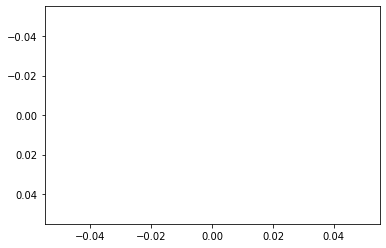

In [21]:
gc.collect (); torch.cuda.empty_cache ()
CFG.warmup_steps = 0.5
CFG.eval_steps   = 0.5
CFG.num_workers  = 8
CFG.train_batch_size = 16
CFG.eval_batch_size  = 16
CFG.freeze = True
CFG.epochs = 5
print (f"***** Training, freeze={CFG.isFreeze} *****")
valid_scores_df = train_main ("../input/shopee-pytorch-siamese-triplet-loss-xlmrobe-cd1846/xlmroberta_256_fold0.pth") 
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.warmup_steps = 0.5
CFG.eval_steps   = 0.5
CFG.num_workers = 8
CFG.train_batch_size = 1
CFG.eval_batch_size  = 1
CFG.isFreeze = False
CFG.epochs = 2
print (f"***** Training, freeze={CFG.isFreeze} *****")
valid_scores_df = train_main ("../input/shopee-pytorch-siamese-triplet-loss-xlmrobe-cd1846/xlmroberta_256_fold0.pth")
valid_scores_df

In [22]:
print ('Done !')

Done !
